In [1]:
import numpy as np
import astropy
from matplotlib import pyplot as plt
import quadpy
from scipy.interpolate import interp1d
import scipy
import math
from numpy import savetxt
from astropy.modeling import models
from astropy import units as u
from sympy import *
from decimal import Decimal
import os
os.chdir('/Users/danielegana/Physicsapps/mesa-r23.05.1/tutorial/LOGS/')
import mesa_reader as mr
import multiprocessing
import subprocess
import rundef
import test
plt.rcParams['text.usetex'] = True



mgdir   = '/Users/danielegana/Dropbox (PI)/TDE metal/'
workdir = os.getcwd()

# Metallicity Run

In [5]:
mesadir   = '/Users/danielegana/Physicsapps/mesa-r23.05.1'

Zlist=[1e-5,1e-4,1e-3,0.012,0.1]


In [6]:
Mlist=[0.1,0.5,1,1.5,2,2.5,3]

In [8]:
for x in Zlist:
    for y in Mlist:
        workdir=mesadir+'/star/work'
        Zdir=mesadir+'/Z'+str(x)+'M'+str(y)
        if not os.path.isdir(Zdir):
            copymesafolder='cp -r '+workdir+' '+Zdir
            os.system(copymesafolder)
            with open(Zdir+'/inlist_project', 'r') as file:
                data = file.readlines()
            file.close() 
            indexz = [x for x in range(len(data)) if 'initial_z' in data[x]]
            data[indexz[0]] = 'initial_z = '+str(x)+'\n'
            data=np.insert(data, indexz[0] + 1, 'max_years_for_timestep=1e8\n', axis=0)
            data=np.insert(data, indexz[0] + 1, 'history_interval=1\n', axis=0)
            indexz = [x for x in range(len(data)) if 'Zbase' in data[x]]
            data[indexz[0]] = 'Zbase = '+str(x)+'\n'
            indexmass = [x for x in range(len(data)) if 'initial_mass' in data[x]]
            data[indexmass[0]] = 'initial_mass = '+str(y)+'\n'
            indexzams = [x for x in range(len(data)) if 'stop_near_zams' in data[x]]
            data[indexzams[0]] = 'stop_near_zams = .false.'
            with open(Zdir+'/inlist_project','w') as file:
                file.writelines(data)
            file.close()

In [9]:
Zmarray=[(Zlist[i],Mlist[j]) for i in range(len(Zlist)) for j in range(len(Mlist))]

In [799]:
# Test func pool function

if __name__ == '__main__':

    num_processes = multiprocessing.cpu_count()  # Number of available CPU cores
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use the `map` function to distribute the work among processes
        printout = pool.starmap(test.testfun, Zmarray)

    # Print or further process the results

In [ ]:
# Run pool

if __name__ == '__main__':

    num_processes = multiprocessing.cpu_count()  # Number of available CPU cores
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use the `map` function to distribute the work among processes
        printout = pool.starmap(rundef.runstar, Zmarray)

    # Print or further process the results

# Import data

In [12]:
Zdirs=[mesadir + f'/starZ{val}/LOGS/history.data' for val in Zlist]
Zdirs=[mesadir+ '/Z'+str(x)+'M'+str(y)+'/LOGS/history.data' for x in Zlist for y in Mlist]
hlist = [mr.MesaData(x) for x in Zdirs]

In [16]:
averageradius=[np.trapz((hlist[x]).R, (hlist[x]).star_age)/max((hlist[x]).star_age) for x in range(0,len(Zdirs))]

In [17]:
radiusproba=[np.multiply(np.diff((hlist[x]).star_age),(hlist[x]).R[0:(len(np.diff((hlist[x]).star_age)))])/max((hlist[x]).star_age) for x in range(0,len(Zdirs))]

In [135]:

# Define the bins for x values
num_bins = 200  # Number of bins for x values
num_binsage=1000
PRbin=np.zeros((len(Zdirs), num_bins))
Rdabin=np.zeros((len(Zdirs), num_bins))
bin_edges=np.zeros((len(Zdirs), num_bins+1))
bin_edgesage=np.zeros(num_binsage+1)


for j in range(len(Zdirs)):
#for j in [0]:
    hist, bin_edges[j] = np.histogram((hlist[j]).R, bins=num_bins)
    hist, bin_edgesage = np.histogram((hlist[j]).star_age, bins=num_binsage)
    interpolatedR = interp1d((hlist[j]).star_age, (hlist[j]).R, kind='linear')  # 'linear' interpolation
    interplist=list(map(interpolatedR,bin_edgesage))
    
# Calculate the time spent in each bin
    for i in range(num_bins):
        indices_in_bin = np.where((interplist >= bin_edges[j,i]) & (interplist < bin_edges[j,i + 1]))[0]

        for x in indices_in_bin:
            if x < len(bin_edgesage)-1:
                temp=interplist[x]*(bin_edgesage[x+1]-bin_edgesage[x])/max((hlist[j]).star_age)
                Rdabin[j,i] += temp
                temp=(bin_edgesage[x+1]-bin_edgesage[x])/max((hlist[j]).star_age)
                PRbin[j,i] += temp/(bin_edges[j,i+1]-bin_edges[j,i])
            else: 
                temp=interplist[x]*(bin_edgesage[x]-bin_edgesage[x-1])/max((hlist[j]).star_age)
                Rdabin[j,i] = Rdabin[j,i]+temp
                temp=(bin_edgesage[x]-bin_edgesage[x-1])/max((hlist[j]).star_age)
                PRbin[j,i] += temp/(bin_edges[j,i+1]-bin_edges[j,i])

In [98]:
def indexZm(Z,M):
     x=Zlist.index(Z)*len(Mlist)+Mlist.index(M)
     return x


# Plots

In [ ]:
averageradius[0]/averageradius[34]

0.023829784533005768

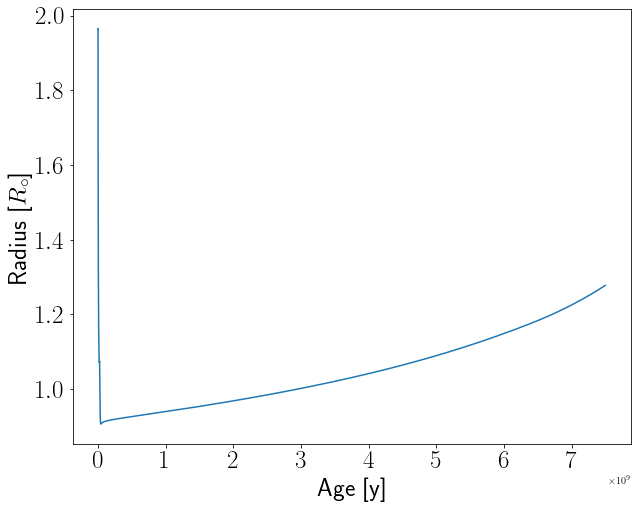

In [847]:
Ztest=0.012
Mtest=1

font=25
plt.figure(figsize=(10,8))
plt.plot((hlist)[indexZm(Ztest,Mtest)].star_age,(hlist)[indexZm(Ztest,Mtest)].R)
plt.ylabel('Radius [$R_\circ$]',fontsize=font)
plt.xlabel('Age [y]',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.show()

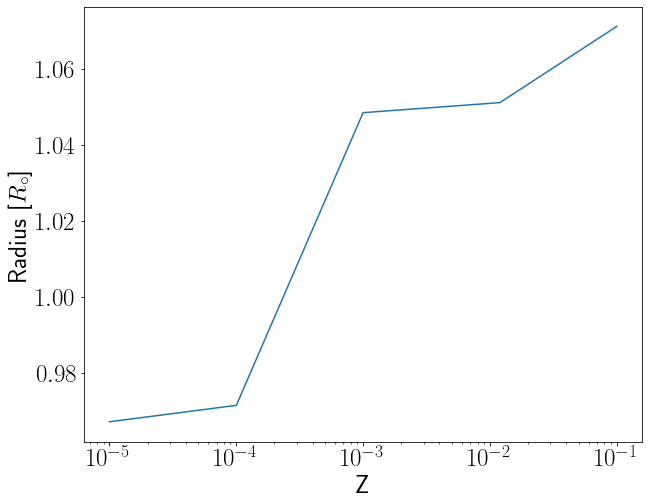

In [108]:
font=25
plt.semilogx(Zlist,[averageradius[i] for i in list(map(lambda x: indexZm(x, 1), Zlist))])
plt.xlabel('Z',fontsize=font)
plt.ylabel('Radius [$R_\circ$]',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.show()

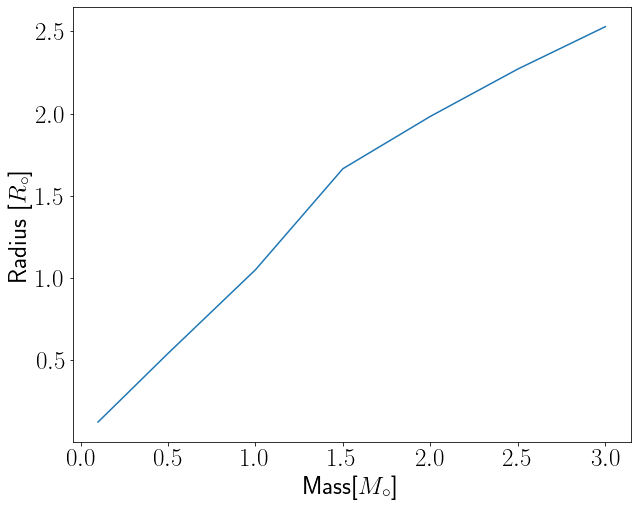

In [160]:
font=25
plt.plot(Mlist,[averageradius[i] for i in list(map(lambda x: indexZm(0.012, x), Mlist))])
plt.xlabel('Mass'+'[$M_\circ$]',fontsize=font)
plt.ylabel('Radius [$R_\circ$]',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.show()

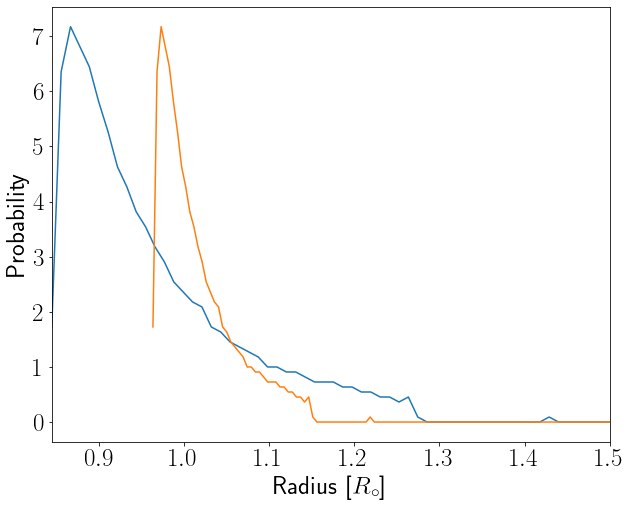

In [136]:
Ztest1=1e-5
Ztest2=0.1
Mtest=1


font=25
plt.plot(bin_edges[indexZm(Ztest1,Mtest),0:len(PRbin[indexZm(Ztest1,Mtest)])],PRbin[indexZm(Ztest1,Mtest)])
plt.plot(bin_edges[indexZm(Ztest2,Mtest),0:len(PRbin[indexZm(Ztest1,Mtest)])],PRbin[indexZm(Ztest1,Mtest)])
plt.xlabel('Radius [$R_\circ$]',fontsize=font)
plt.ylabel('Probability',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlim([min(bin_edges[indexZm(Ztest1,Mtest)]), 1.5])
plt.show()

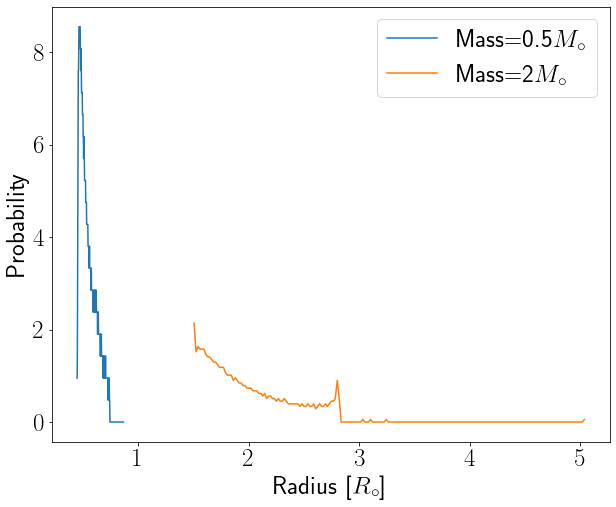

In [152]:
Ztest=0.012
Mtest1=0.5
Mtest2=2


font=25
plt.plot(bin_edges[indexZm(Ztest,Mtest1),0:len(PRbin[indexZm(Ztest,Mtest1)])],PRbin[indexZm(Ztest,Mtest1)],label='Mass='+str(Mtest1)+'$M_\circ$')
plt.plot(bin_edges[indexZm(Ztest,Mtest2),0:len(PRbin[indexZm(Ztest,Mtest2)])],PRbin[indexZm(Ztest,Mtest2)],label='Mass='+str(Mtest2)+'$M_\circ$')
plt.xlabel('Radius [$R_\circ$]',fontsize=font)
plt.ylabel('Probability',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.legend(fontsize=font)
plt.show()

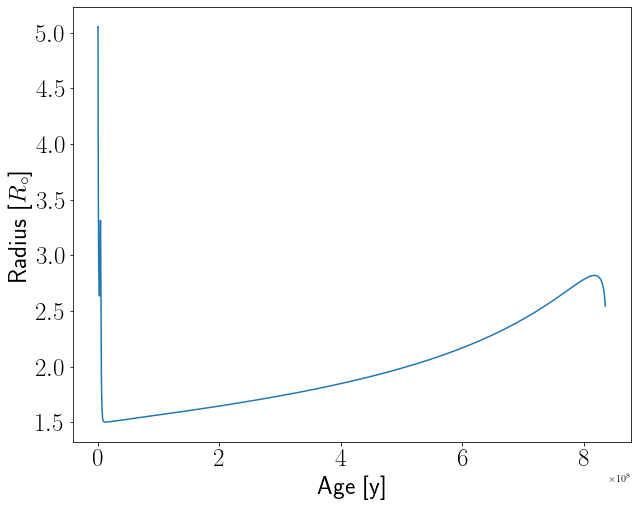

In [124]:
Ztest=0.012
Mtest=2

font=25
plt.plot((hlist)[indexZm(Ztest,Mtest)].star_age,(hlist)[indexZm(Ztest,Mtest)].R)
plt.ylabel('Radius [$R_\circ$]',fontsize=font)
plt.xlabel('Age [y]',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.show()

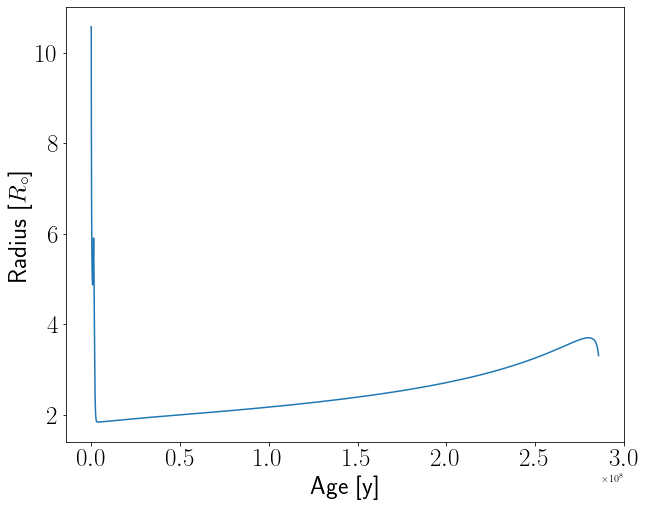

In [126]:
Ztest=0.012
Mtest=3

font=25
plt.plot((hlist)[indexZm(Ztest,Mtest)].star_age,(hlist)[indexZm(Ztest,Mtest)].R)
plt.ylabel('Radius [$R_\circ$]',fontsize=font)
plt.xlabel('Age [y]',fontsize=font)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.show()